In [ ]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model

null performances after coercion: 0
after saturation filter 995
after filter num benchmarks 735
after merge with model versions 740
after merge with benchmark dates 740
Original number of rows: 740
Number of rows after aggregation: 658


In [3]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark, anchor_difficulty, anchor_slope)

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 36, initial cost 2.3912e+01, final cost 1.6297e+00, first-order optimality 7.03e-05.


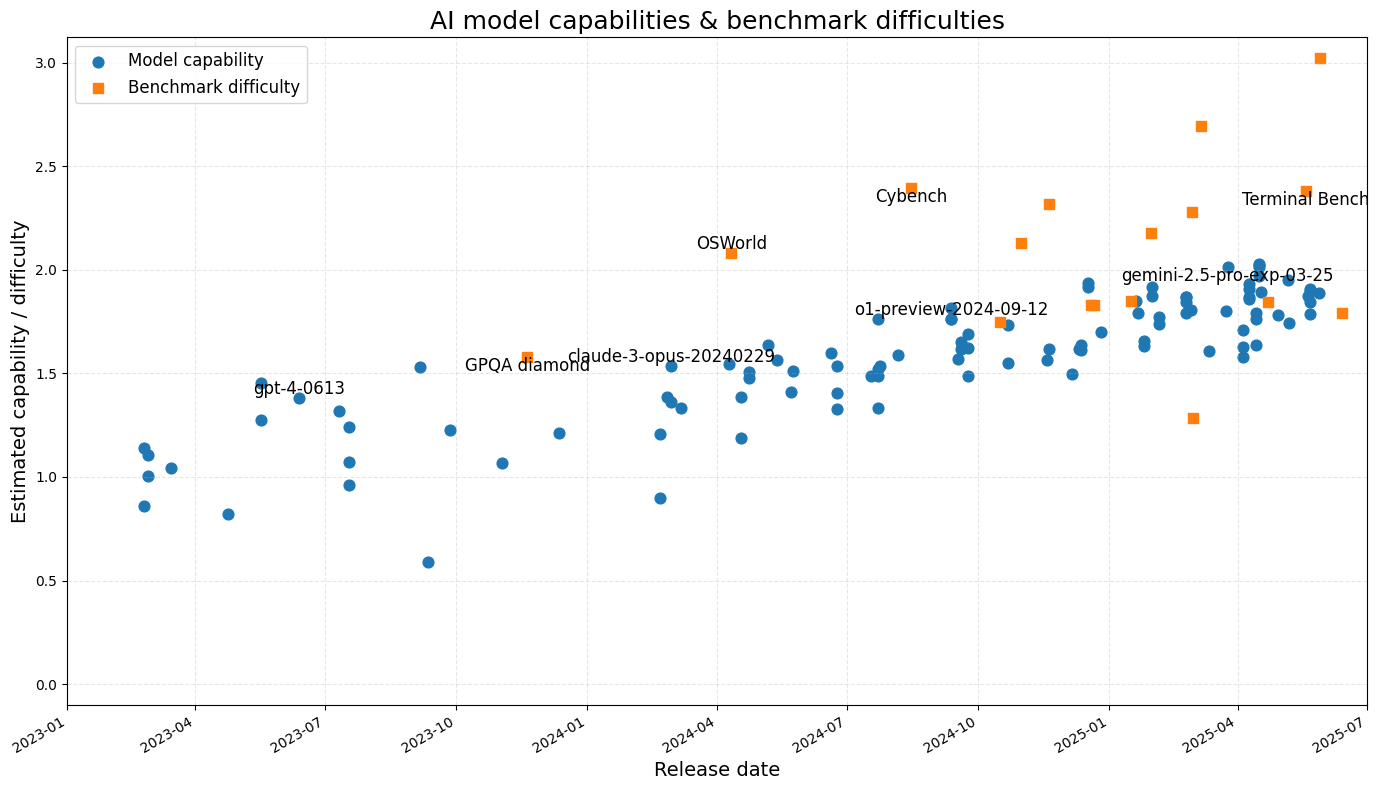

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


Bootstrapped mean rate: 0.3173 capability units/year
95% confidence interval: [0.2615, 0.3914]


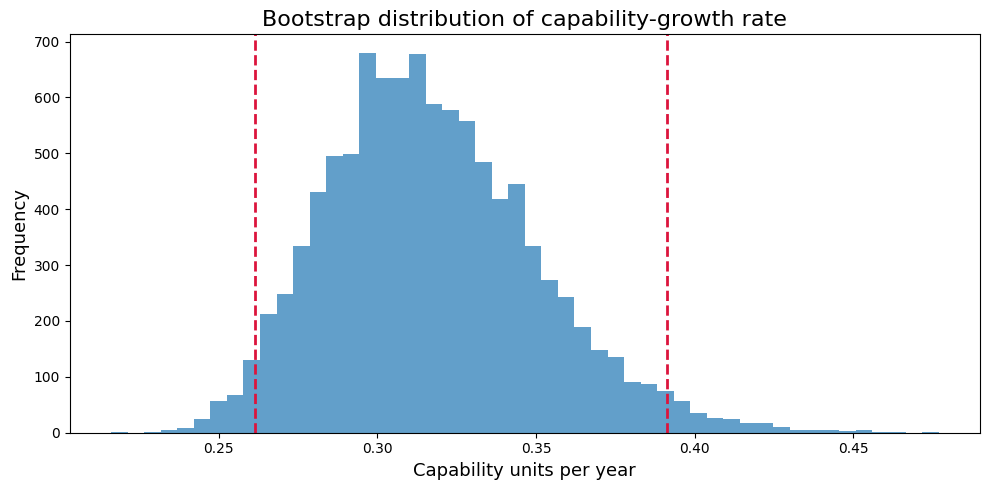

In [5]:
n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

x_full = cap_dates_num                       # days-since-0000-12-31 (float64)
y_full = cap_values.to_numpy()         # capability values (float64)

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()

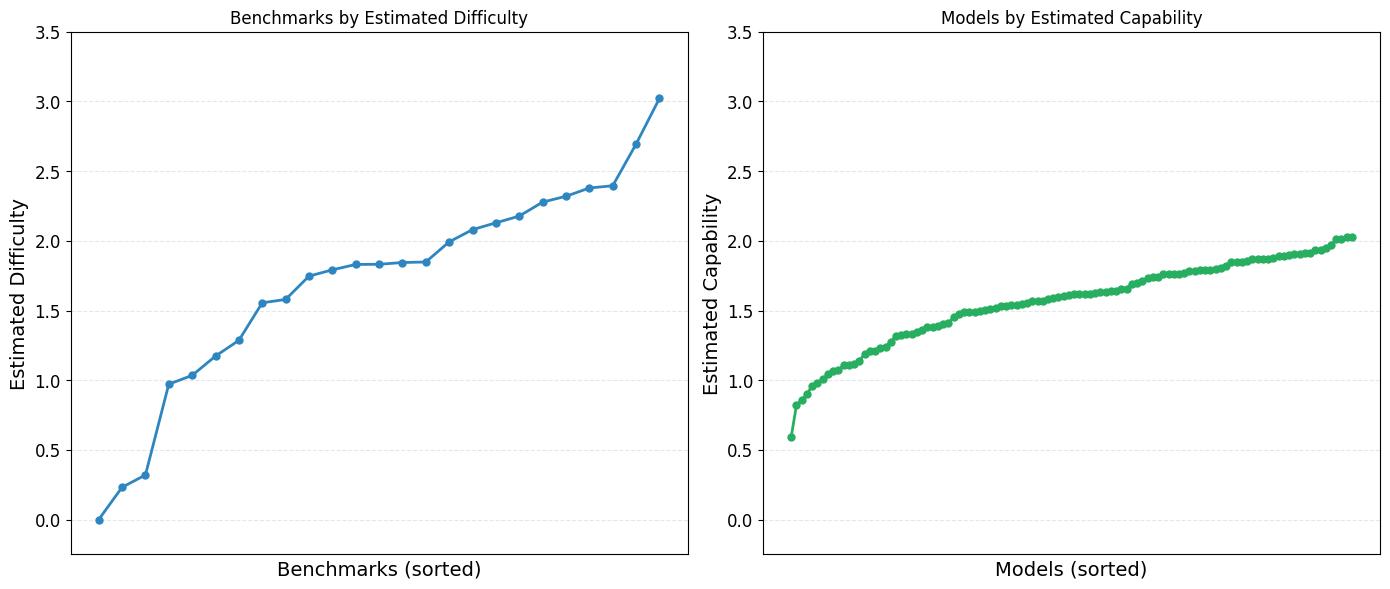

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# ---------- 1) Prepare the two ordered data sets ----------
# ------------- (exactly as in your originals) -------------
sorted_bd = df_db1.sort_values(by="estimated_difficulty").reset_index(drop=True)
bd_values  = sorted_bd["estimated_difficulty"]
bd_names   = sorted_bd["benchmark_name"]
bd_ids     = sorted_bd["benchmark_id"]
bd_idx     = np.arange(len(bd_values))

sorted_cm = df_cm1.sort_values(by="estimated_capability").reset_index(drop=True)
cm_values  = sorted_cm["estimated_capability"]
cm_names   = sorted_cm["model"]
cm_ids     = sorted_cm["model_id"]
cm_idx     = np.arange(len(cm_values))

# ---------- 2) Create a single figure with two sub-axes ----------
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 8), sharey=False  # sharey=False because scales differ
)

# ---------- 3) First subplot: benchmark difficulties ----------
ax1.plot(bd_idx, bd_values, marker='o', linestyle='-', linewidth=2,
         markersize=5, color='#2E86C1')
ax1.set_xlabel('Benchmarks (sorted)', fontsize=14)
ax1.set_ylabel('Estimated Difficulty', fontsize=14)
ax1.set_title('Benchmarks by Estimated Difficulty')
# ax1.set_xticks(bd_idx)
# ax1.set_xticklabels(bd_ids, rotation=90)
ax1.set_xticks([])
ax1.grid(True, alpha=0.3, linestyle='--')
# ax1.axhspan(bd_values.min(), bd_values.max(), alpha=0.1, color='skyblue')

ax1.set_ylim(-0.25, 3.5)
ax1.tick_params(axis='y', labelsize=12)

# # optional min / max call-outs
# ax1.annotate(f'Min: {bd_values.min():.2f}', xy=(0, bd_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax1.annotate(f'Max: {bd_values.max():.2f}', xy=(len(bd_values)-1, bd_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 4) Second subplot: model capabilities ----------
ax2.plot(cm_idx, cm_values, marker='o', linestyle='-', linewidth=2,
         markersize=5, color='#27AE60')
ax2.set_xlabel('Models (sorted)', fontsize=14)
ax2.set_ylabel('Estimated Capability', fontsize=14)
ax2.set_title('Models by Estimated Capability')
# ax2.set_xticks(cm_idx)
# ax2.set_xticklabels(cm_ids, rotation=90)
ax2.set_xticks([])
ax2.grid(True, alpha=0.3, linestyle='--')
# ax2.axhspan(cm_values.min(), cm_values.max(), alpha=0.1, color='lightgreen')

ax2.set_ylim(-0.25, 3.5)
ax2.tick_params(axis='y', labelsize=12)

# ax2.annotate(f'Min: {cm_values.min():.2f}', xy=(0, cm_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax2.annotate(f'Max: {cm_values.max():.2f}', xy=(len(cm_values)-1, cm_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 5) Finish up ----------
# fig.suptitle('Benchmark Difficulty vs. Model Capability', fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])   # leave room for the suptitle
plt.subplots_adjust(bottom=0.25)         # extra space for x-tick labels


plt.savefig("model_and_benchmark_ranking.pdf")

plt.show()
